In [1]:
import seaborn as sns
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import ppscore as pps
import datetime
import ppscore as pps
import random
import bokeh
from bokeh.plotting import figure, show
pd.set_option("display.max_columns",80)
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.set_option("display.max_rows",80)
import tslumen
import tqdm as notebook_tqdm
import datetime as dt
from tslumen import HtmlReport
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tqdm as notebook_tqdm
from tqdm import tqdm


c:\Users\nati\Desktop\Implementations\ImplementationsVenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_data(path):
    df = pd.read_csv(path,parse_dates = ["Date"])
    df = df.sort_values(by="Date").reset_index(drop=True)
    display(df.head())
    return df

In [41]:
PATH = r"C:\Users\nati\Desktop\Implementations\LSTM\SOL-USD.csv"
df = read_data(PATH)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-10,0.832005,1.313487,0.694187,0.951054,0.951054,87364276
1,2020-04-11,0.951054,1.049073,0.765020,0.776819,0.776819,43862444
2,2020-04-12,0.785448,0.956670,0.762426,0.882507,0.882507,38736897
3,2020-04-13,0.890760,0.891603,0.773976,0.777832,0.777832,18211285
4,2020-04-14,0.777832,0.796472,0.628169,0.661925,0.661925,16747614


In [31]:
#Check for NA's
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<AxesSubplot: ylabel='Close'>

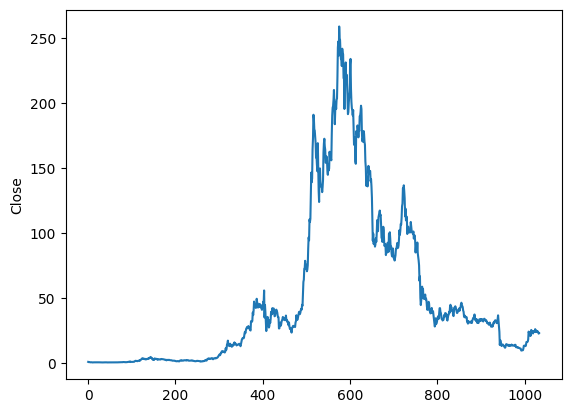

In [32]:
sns.lineplot(df["Close"])

In [33]:
# Create features
def create_features(df):
    # Create a new column for the day of the week
    if "Date" not in df.columns:
        df["Date"] = df.index
    df['Date'] = pd.to_datetime(df["Date"])
    df['day_of_week'] = df['Date'].apply(lambda x: datetime.datetime.weekday(x))
    df['month'] = pd.DatetimeIndex(df['Date']).month
    return df.drop(columns=["Date"])


In [34]:
#Function to create Squences of Data for LSTM model
def create_sequences(input_data:pd.DataFrame,target_column,sequence_length):
    sequences = []
    data_size = len(input_data)
    for sample in tqdm(range(data_size - sequence_length)):
        #Sliding window for sequences
        sequence = input_data[sample:sample+sequence_length].values
        #Position of label
        label_position = sample + sequence_length
        label = input_data.iloc[label_position][target_column]
        #Append to sequences
        sequences.append((sequence,label))
    return sequences

In [35]:
def split_data(train_ratio,val_ratio,data):
    total = len(data)
    train = round(train_ratio*total)
    val = round(train + val_ratio*total)
    train_df = df[:train]
    validation_df = df[train:val]
    test_df = df[val:]

    return train_df,validation_df,test_df

In [42]:
def scale_data(df):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    data = scaler.fit_transform(df)
    return pd.DataFrame(data,columns=df.columns)

In [144]:
train_df,val_df,test_df = split_data(data = df,train_ratio = 0.8,val_ratio = 0.1)
train_df,val_df,test_df = create_features(train_df),create_features(val_df),create_features(test_df)
train_df,val_df,test_df = scale_data(train_df),scale_data(val_df),scale_data(test_df)

In [145]:
train_df

,Open,High,Low,Close,Adj Close,Volume,day_of_week,month
0,-0.834144,-0.833558,-0.832587,-0.833606,-0.833606,-0.667916,0.499622,-0.730583
1,-0.832334,-0.837416,-0.831457,-0.836258,-0.836258,-0.695175,0.999849,-0.730583
2,-0.834851,-0.838765,-0.831499,-0.834649,-0.834649,-0.698387,1.500076,-0.730583
3,-0.833251,-0.839714,-0.831314,-0.836242,-0.836242,-0.711249,-1.501286,-0.730583
4,-0.834967,-0.841102,-0.833639,-0.838006,-0.838006,-0.712166,-1.001059,-0.730583
...,...,...,...,...,...,...,...,...
822,-0.289083,-0.317318,-0.312167,-0.338792,-0.338792,-0.139763,-1.501286,0.184860
823,-0.338149,-0.349302,-0.321409,-0.349537,-0.349537,-0.148429,-1.001059,0.184860
824,-0.349047,-0.342905,-0.334133,-0.316765,-0.316765,0.100169,-0.500832,0.184860
825,-0.316152,-0.309616,-0.306529,-0.283330,-0.283330,0.104572,-0.000605,0.184860


In [146]:
SEQUENCE_LENGTH = 7
TARGET = "Close"

train_sequences = create_sequences(train_df,TARGET,SEQUENCE_LENGTH)
validation_sequences = create_sequences(val_df,TARGET,SEQUENCE_LENGTH)
test_sequences = create_sequences(test_df,TARGET,SEQUENCE_LENGTH)



100%|██████████| 97/97 [00:00<00:00, 24251.76it/s]


# Pytorch Dataset

In [147]:
from torch.utils.data import Dataset,DataLoader

class SOLDataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,idx):
        sequence,label = self.sequences[idx]
        seq = torch.tensor(sequence.astype(float)).float()
        label = torch.tensor(label).float()
        
        return seq,label

train_df = SOLDataset(train_sequences)
train_dataloader = DataLoader(train_df,batch_size=50,shuffle=False)
validation_df = SOLDataset(validation_sequences)
validation_dataloader = DataLoader(validation_df,batch_size=50,shuffle=False)
test_df = SOLDataset(test_sequences)
test_dataloader = DataLoader(test_df,batch_size=1,shuffle=False)



In [130]:
seq,label = next(iter(train_dataloader))
print(seq.size())
print(label.size())

torch.Size([50, 14, 8])
torch.Size([50])


# LSTM Model

In [148]:
class LSTMPredictor(nn.Module):
    def __init__(self,n_features,n_hidden,n_layers):
        super(LSTMPredictor,self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_features = n_features
        
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers , 
            dropout = 0.5
        
        )
        self.regressor = nn.Linear(n_hidden,1)

    
    def forward(self,x):
        #Output is  output(samples in batch,seq_len,D*hidden_size) ,h_n(num_layers,batch num,hidden_size) , cn(num_layers,hidden_size)
        _ , (hn,cn) = self.lstm(x) 
        output = self.regressor(hn[-1,:,:])
        return output

In [149]:
class GRUModel(nn.Module):
    def __init__(self,num_features,num_layers,num_hidden,dropout):
        super(GRUModel,self).__init__()
        self.gru = nn.GRU(
            input_size = num_features,
            num_layers = num_layers ,
            hidden_size = num_hidden ,
            bias = True , 
            batch_first = True , 
            dropout = dropout
        )

        self.regressor = nn.Linear(num_hidden,1)

    def forward(self,x):
        out,hn = self.gru(x)
        output = hn[-1,:,:]
        output = self.regressor(output)
        return output


In [170]:
class RNNVanilla(nn.Module):
    def __init__(self,num_layers,num_hidden,num_features):
        super(RNNVanilla,self).__init__()
        self.rnn = nn.RNN(input_size = num_features,
                          hidden_size = num_hidden,
                          num_layers = num_layers,
                          batch_first = True,
                          bias = True,
                          dropout = 0.3)
        self.regressor = nn.Linear(num_hidden,1)

    def forward(self,x):
        output,hn = self.rnn(x)
        out = hn[-1,:,:]
        out = self.regressor(out)
        return out


In [171]:
def train_loop(data_loader, model,device,loss_fn,optimizer,print_every_n=200):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    
    train_loss=0

    for batch,(X,y) in enumerate(data_loader):
        # Setting to Device
        X = X.to(device)
        y = y.to(device)
        # Predict
        pred = model(X)
        # Calculate Loss
        loss = loss_fn(pred,y)
        # Add loss
        train_loss += loss
        # Backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= size  
    return train_loss

def validation_loop(data_loader,model,device,loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    val_loss=0
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred,y).item()
        
    val_loss /= size
    print(f'MSELoss =  {val_loss:2f}')
    return val_loss

# Model 1 - LSTM

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.005

model = LSTMPredictor(8,32,1)
model.to(device)

criterion = nn.MSELoss()
criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Model 2 - GRU

In [163]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.005

model = GRUModel(num_features=8,num_layers=2,num_hidden=16,dropout=0.3)
model.to(device)

criterion = nn.MSELoss()
criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Model 3 - Vanilla RNN

In [186]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.01

model = RNNVanilla(num_features=8,num_layers=1,num_hidden=64)
model.to(device)

criterion = nn.MSELoss()
criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [187]:
import time
results = []
# define the number of epochs and early stopping patience
epochs = 500
patience = 100
best_loss = np.inf

for epoch in range(epochs):
    start_time = time.time()
    train_loss = train_loop(train_dataloader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss = validation_loop(validation_dataloader, model, device, criterion)

    results.append({'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    if val_loss < best_loss:
        # torch.save(model.state_dict(), f'model_LSTM{epoch}.pth')
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break


MSELoss =  0.023047
MSELoss =  0.025169
MSELoss =  0.022421
MSELoss =  0.018352
MSELoss =  0.036719
MSELoss =  0.019037
MSELoss =  0.030191
MSELoss =  0.017809
MSELoss =  0.020564
MSELoss =  0.031395
MSELoss =  0.018962
MSELoss =  0.024906
MSELoss =  0.019732
MSELoss =  0.024114
MSELoss =  0.021511
MSELoss =  0.029601
MSELoss =  0.025404
MSELoss =  0.019987
MSELoss =  0.024367
MSELoss =  0.026520
MSELoss =  0.018633
MSELoss =  0.019764
MSELoss =  0.020567
MSELoss =  0.026510
MSELoss =  0.025324
MSELoss =  0.019939
MSELoss =  0.023554
MSELoss =  0.017599
MSELoss =  0.020919
MSELoss =  0.026608
MSELoss =  0.020748
MSELoss =  0.020779
MSELoss =  0.024897
MSELoss =  0.023906
MSELoss =  0.019577
MSELoss =  0.026081
MSELoss =  0.019794
MSELoss =  0.024068
MSELoss =  0.020925
MSELoss =  0.031256
MSELoss =  0.024412
MSELoss =  0.024193
MSELoss =  0.017667
MSELoss =  0.023687
MSELoss =  0.025791
MSELoss =  0.019847
MSELoss =  0.026718
MSELoss =  0.021319
MSELoss =  0.020920
MSELoss =  0.024281


In [ ]:
test_sequences

In [188]:
results = pd.DataFrame(results)

<AxesSubplot: >

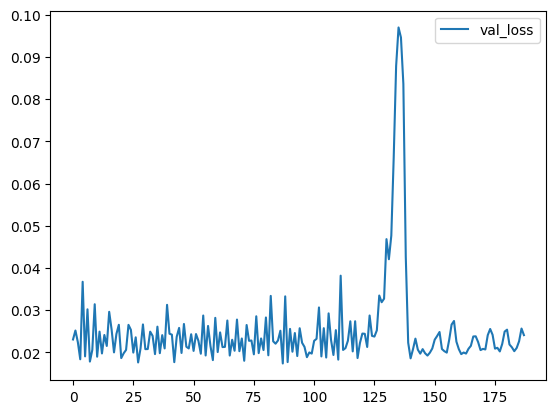

In [189]:
results.plot()

In [167]:
GT = []
PREDS = []
size=len(test_dataloader.dataset)
num_batches = len(test_dataloader)
test_loss=0
model.eval()
with torch.no_grad():
    for X,y in test_dataloader:
        # print(y)
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        print(pred)
        PREDS.append(pred.detach())
        GT.append(y.detach())
        test_loss += criterion(pred,y).item()
    
    test_loss /= size
    print(f'MSELoss =  {test_loss:2f}')


tensor([[1.7707]], device='cuda:0')
tensor([[1.6997]], device='cuda:0')
tensor([[1.8556]], device='cuda:0')
tensor([[2.0922]], device='cuda:0')
tensor([[2.0420]], device='cuda:0')
tensor([[2.0051]], device='cuda:0')
tensor([[1.9669]], device='cuda:0')
tensor([[1.6207]], device='cuda:0')
tensor([[1.3440]], device='cuda:0')
tensor([[1.0034]], device='cuda:0')
tensor([[0.7687]], device='cuda:0')
tensor([[0.5746]], device='cuda:0')
tensor([[0.0847]], device='cuda:0')
tensor([[-0.3570]], device='cuda:0')
tensor([[-0.4366]], device='cuda:0')
tensor([[-0.4917]], device='cuda:0')
tensor([[-0.5342]], device='cuda:0')
tensor([[-0.5742]], device='cuda:0')
tensor([[-0.6334]], device='cuda:0')
tensor([[-0.6846]], device='cuda:0')
tensor([[-0.7224]], device='cuda:0')
tensor([[-0.7149]], device='cuda:0')
tensor([[-0.6614]], device='cuda:0')
tensor([[-0.6038]], device='cuda:0')
tensor([[-0.5564]], device='cuda:0')
tensor([[-0.5398]], device='cuda:0')
tensor([[-0.5428]], device='cuda:0')
tensor([[-0.55

In [168]:
GT_T = []
for item in GT:
    for num in item:
        GT_T.append(num.detach().cpu().item())

PREDS_T = []
for item in PREDS:
    for num in item:
        PREDS_T.append(num.detach().cpu().item())


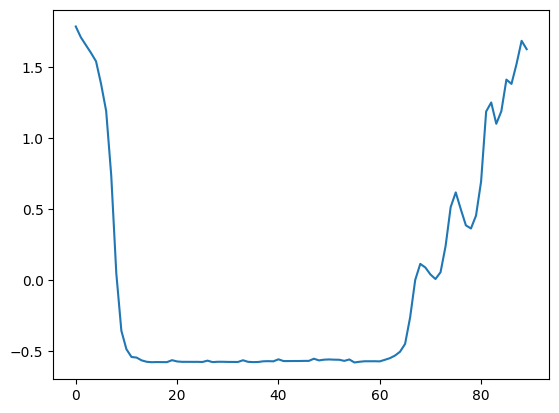

In [93]:
plt.plot(PREDS_T)

In [ ]:
PREDS_T

In [ ]:
len(GT_T)

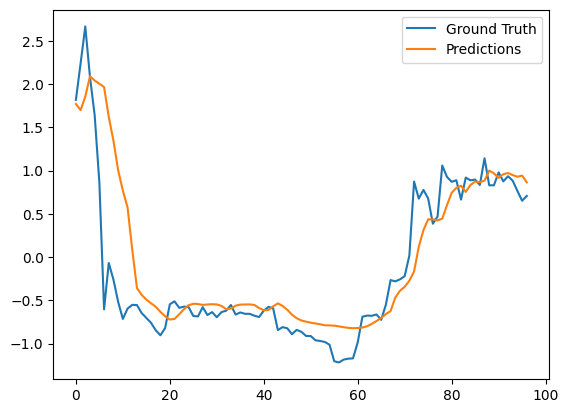

In [169]:
plt.plot(GT_T,label="Ground Truth")
plt.plot(PREDS_T,label = "Predictions")
plt.legend()
plt.show()
